In [87]:
import os
import sklearn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Подготовка данных к вычислительному эксперименту

In [47]:
domens_list = ["music", "baby", "software", "books", "kitchen_&_housewares"]

def review_parser(text):
  s = text.splitlines()
  rev = []
  for i in range(len(s)):
      if s[i] == '<review_text>':
          rev.append(s[i+1])
  return rev

In [48]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/82 Task /Data/sorted_data"

objects = []
BL = 0
for domen in tqdm(domens_list):
  for _type in ["negative", "positive"]:
    with open(os.path.join(DATA_PATH, domen, "{}.review".format(_type)), "rb") as f:
      list_of_good_lines = []
      for line in f.read().splitlines():
        try:
          list_of_good_lines.append(line.decode("utf-8"))
        except:
          BL += 1
          pass
      temp =  review_parser("\n".join(list_of_good_lines))
      for text in temp:
        item = dict()
        item["text"] = text
        item["domen"] = domen
        item["sentiment"] = 0 if _type == "negative" else 1

        objects.append(item)

# Анализ данных

In [49]:
domens = [item["domen"] for item in objects]
classes = [item["sentiment"] for item in objects]
texts = [item["text"] for item in objects]

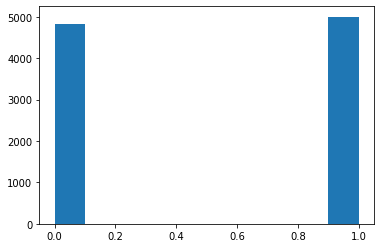

In [50]:
plt.hist(classes)
plt.show()

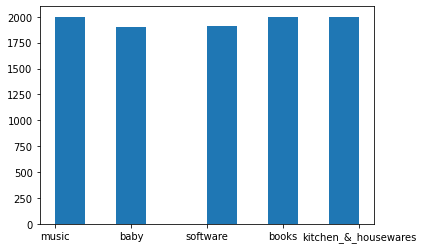

In [51]:
plt.hist(domens)
plt.show()

In [81]:
text_train, text_test, classes_train, classes_test = train_test_split(texts, classes, random_state = 42)

# Эксперимент с одной моделью

In [82]:
embedder = TfidfVectorizer()
embedder.fit(text_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [85]:
X_train = embedder.transform(text_train).toarray()
X_test = embedder.transform(text_test).toarray()
y_train = classes_train
y_test = classes_test

In [93]:
X_train.shape

(7361, 25770)

In [86]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
pred = model.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3601
           1       0.91      0.90      0.91      3760

    accuracy                           0.91      7361
   macro avg       0.91      0.91      0.91      7361
weighted avg       0.91      0.91      0.91      7361



In [89]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1214
           1       0.79      0.83      0.81      1240

    accuracy                           0.80      2454
   macro avg       0.80      0.80      0.80      2454
weighted avg       0.80      0.80      0.80      2454



# Эксперимент с мультимоделью



In [92]:
from mixturelib.mixture import MixtureEM
from mixturelib.local_models import EachModel
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet

In [ ]:
class EachModelLogistic(EachModel):
    r"""A model for solving the logistic regression problem
    :math:`\textbf{y} = \sigma(\textbf{x}^{\mathsf{T}}\textbf{w})`.
    The model uses an gradient descent solution for estimation :math:`\textbf{w}`.
    Also model finds a distribution of model parameters :math:`\textbf{w}`.
    Distribution is 
    :math:`\textbf{w} \sim \mathcal{N}\bigr(\hat{\textbf{w}}, \textbf{A}\bigr)`
    .. warning::
        The priors `A` and `w` must be set or not together.
    :param input_dim: The number of feature in each object. Must be positive.
    :type input_dim: int
    :param device: The device for pytorch. 
        Can be 'cpu' or 'gpu'. Default 'cpu'.
    :type device: string
    :param A: The tensor of shape input_dim :math:`\times` input_dim. It is a 
        prior covariance matrix for model parameters.
        Also can be the tensor of shape input_dim. In this case, it is a 
        diagonal of prior covariance matrix for model parameters, and all 
        nondiagonal values are zerous.
    :type A: FloatTensor
    :param w: The tensor of shape input_dim. It is a prior mean for model 
        parameters
    :type w: FloatTensor
    :param OptimizedHyper: The set of hyperparameters that will be optimized.
        Default all hyperparameters will be optimized.
    :type OptimizedHyper: set
    """
    def __init__(self,
                 input_dim=20,
                 device='cpu',
                 A=None,
                 w=None,
                 OptimizedHyper=set(['w_0', 'A', 'beta'])):
        """Constructor method
        """
        super(EachModelLinear, self).__init__()

        self.input_dim = input_dim
        self.device = device
        self.OptimizedHyper = OptimizedHyper
        self.A = A
            
        self.W = (1e-5)*torch.randn(input_dim, 1, device = self.device)
        r"""Object :math:`\textbf{W}` is a model parameters"""

        if w is not None:
            self.w_0 = w.view([-1, 1]).clone()
            self.W.data = self.w_0.data.clone() \
                          + (1e-5)*torch.randn(input_dim, 1,
                                               device = self.device)
        else:
            self.w_0 = w
        
        self.B = torch.eye(input_dim, device = self.device)
        r"""Object :math:`\textbf{B}` is a covariance matrix for variational 
        distribution"""

        if self.A is not None:
            if len(self.A.shape) == 1:
                self.B.data = torch.diag(self.A).data.clone()
            else:
                self.B.data = self.A.data.clone()
        
    def forward(self, input):
        r"""Returns model prediction for the given input data.
        Linear prediction is :math:`input@w`.
        .. warning::
            The number `num_answers` can be just `1`.
        
        :param input: The tensor of shape
            `num_elements` :math:`\times` `num_feature`.
        :type input: FloatTensor.
        :return: The tensor of shape
            `num_elements` :math:`\times` `num_answers`.
            Model answers for the given input data
        :rtype: FloatTensor
        """
        return input@self.W
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        r"""Returns the local part of new Parameter.
    
        .. warning::
            Return local part must be aditive to Parameter, because new 
            value of Parameter is sum of local part from all local model.
        .. warning::
            The number `num_answers` can be just `1`.
        :param X: The tensor of shape 
            `num_elements` :math:`\times` `num_feature`.
        :type X: FloatTensor
        :param Y: The tensor of shape 
            `num_elements` :math:`\times` `num_answers`.
        :type Y: FloatTensor
        :param Z: The tensor of shape `num_elements` :math:`\times` `1`.
        :type Z: FloatTensor
        :param HyperParameters: The dictionary of all hyper parametrs.
            Where `key` is string and `value` is FloatTensor.
        :type HyperParameters: dict
        :param Parameter: The key from `HyperParameters` dictionary.
            The name of the hyperparameter to be optimized.
        :type Parameter: string
        :return: A local part of new `HyperParameters[Parameter]` value.
        :rtype: FloatTensor
        """
        pass
        
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        r"""Returns expected log-likelihod of a given vector of answers for
        given data seperated. The expectation is taken according to the model 
        parameters :math:`\mathsf{E}p\bigr(Y|X\bigr)`.
        .. warning::
            The number `num_answers` can be just `1`.
        :param X: The tensor of shape 
            `num_elements` :math:`\times` `num_feature`.
        :type X: FloatTensor
        :param Y: The tensor of shape
            `num_elements` :math:`\times` `num_answers`.
        :type Y: FloatTensor
        :param HyperParameters: The dictionary of all hyper parametrs.
            Where `key` is string and `value` is FloatTensor.
        :type HyperParameters: dict
        :return: The tensor of shape `num_elements` :math:`\times` `1`.
        :rtype: FloatTensor
        """
        pass
        

    def E_step(self, X, Y, Z, HyperParameters):
        r"""Doing E-step of EM-algorithm. Finds variational probability `q` 
        of model parameters.

        .. warning::
            The number `num_answers` can be just `1`.
        :param X: The tensor of shape 
            `num_elements` :math:`\times` `num_feature`.
        :type X: FloatTensor
        :param Y: The tensor of shape 
            `num_elements` :math:`\times` `num_answers`.
        :type Y: FloatTensor
        :param Z: The tensor of shape `num_elements` :math:`\times` `1`.
        :type Z: FloatTensor
        :param HyperParameters: The dictionary of all hyper parametrs.
            Where `key` is string and `value` is FloatTensor.
        :type HyperParameters: dict
        """
        pass

    def M_step(self, X, Y, Z, HyperParameters):
        r"""Doing M-step of EM-algorithm. Finds model hyper parameters.

        .. warning::
            The number `num_answers` can be just `1`.
        :param X: The tensor of shape 
            `num_elements` :math:`\times` `num_feature`.
        :type X: FloatTensor
        :param Y: The tensor of shape 
            `num_elements` :math:`\times` `num_answers`.
        :type Y: FloatTensor
        :param Z: The tensor of shape `num_elements` :math:`\times` `1`.
        :type Z: FloatTensor
        :param HyperParameters: The dictionary of all hyper parametrs.
            Where `key` is string and `value` is FloatTensor.
        :type HyperParameters: dict
        """
        pass


  
     

## To be continued...